# TASK 1:

In [2]:
library(httr)
library(jsonlite)

url_coinmarcap <- "https://api.coinmarketcap.com"
path_ticker <- "v1/ticker/"

raw.data <- GET(url = url_coinmarcap, path = path_ticker)
raw.content <- rawToChar(raw.data$content)

neat_content <- fromJSON(raw.content)

head(neat_content)


id,name,symbol,rank,price_usd,price_btc,24h_volume_usd,market_cap_usd,available_supply,total_supply,max_supply,percent_change_1h,percent_change_24h,percent_change_7d,last_updated
bitcoin,Bitcoin,BTC,1,10594.7,1.0,7144510000.0,179104198102,16905075.0,16905075.0,21000000.0,0.42,-5.1,-1.11,1520418566
ethereum,Ethereum,ETH,2,785.721,0.0744509,1900980000.0,77029464152.0,98036662.0,98036662.0,NA,0.36,-6.65,-10.11,1520418552
ripple,Ripple,XRP,3,0.907219,0.00008596,776213000.0,35464965871.0,39091956706.0,99992520283.0,100000000000,0.32,-5.47,-2.27,1520418540
bitcoin-cash,Bitcoin Cash,BCH,4,1160.8,0.109991,437830000.0,19738765560.0,17004450.0,17004450.0,21000000.0,0.34,-6.04,-5.93,1520418551
litecoin,Litecoin,LTC,5,191.059,0.0181038,664559000.0,10607654101.0,55520306.0,55520306.0,84000000.0,0.4,-6.9,-10.44,1520418541
cardano,Cardano,ADA,6,0.267494,0.00002535,121500000.0,6935335806.0,25927070538.0,31112483745.0,45000000000.0,0.34,-9.27,-16.77,1520418554


## 2. Full dataset, filtering, and reproducibility

The previous API call returns only the first 100 coins, and we want to explore as many coins as possible. Moreover, we can't produce reproducible analysis with live online data. To solve these problems, we will load a CSV we conveniently saved on the 6th of December of 2017 using the API call https://api.coinmarketcap.com/v1/ticker/?limit=0 named datasets/coinmarketcap_06122017.csv. 

In [3]:
# Reading datasets/coinmarketcap_06122017.csv into pandas

dec6 <- read.csv('datasets/coinmarketcap_06122017.csv')


# Selecting the 'id' and the 'market_cap_usd' columns
market_cap_raw <- dec6[, c("id", "market_cap_usd")]

# Counting the number of values
# ... YOUR CODE FOR TASK 2 ...
lapply(market_cap_raw, function(x) {length(x[!is.na(x)])})

$id
[1] 1326

$market_cap_usd
[1] 1031

## 3. Discard the cryptocurrencies without a market capitalization

Why do the count() for id and market_cap_usd differ above? It is because some cryptocurrencies listed in coinmarketcap.com have no known market capitalization, this is represented by NaN in the data, and NaNs are not counted by count(). These cryptocurrencies are of little interest to us in this analysis, so they are safe to remove.

In [4]:
# Filtering out rows without a market capitalization
# cap = market_cap_raw.query('market_cap_usd > 0')

cap <- market_cap_raw[!is.na(market_cap_raw$market_cap_usd),]

# Counting the number of values again
# ... YOUR CODE FOR TASK 3 ...

nrow(cap)

[1] 1031

## 4. How big is Bitcoin compared with the rest of the cryptocurrencies?

At the time of writing, Bitcoin is under serious competition from other projects, but it is still dominant in market capitalization. Let's plot the market capitalization for the top 10 coins as a barplot to better visualize this.

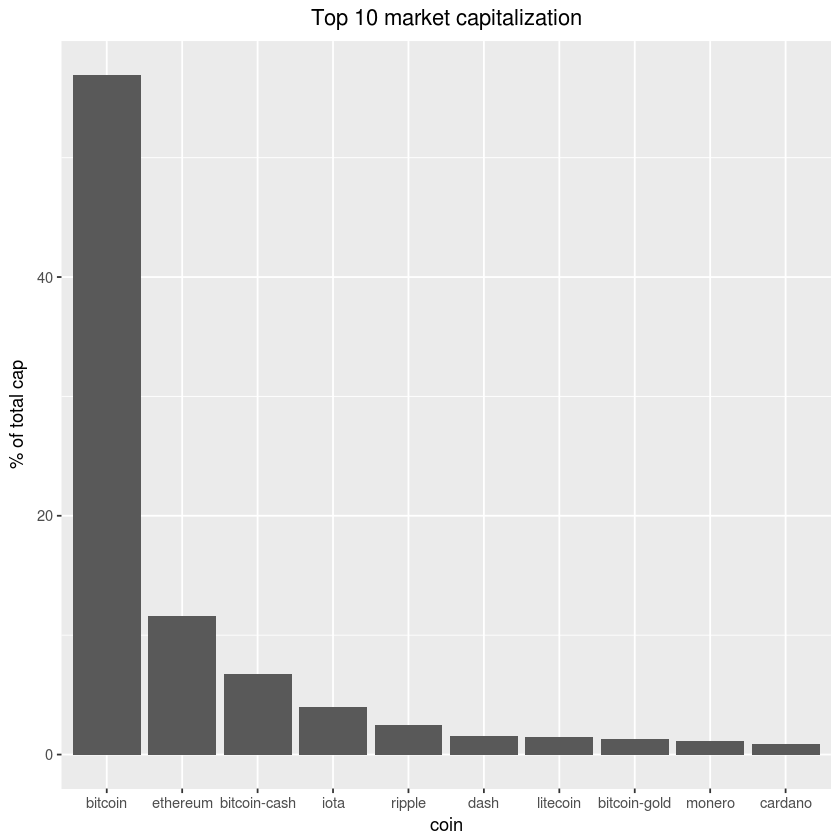

In [5]:
#Declaring these now for later use in the plots
TOP_CAP_TITLE = 'Top 10 market capitalization'
TOP_CAP_YLABEL = '% of total cap'

# Selecting the first 10 rows and setting the index
cap10 = head(cap, 10)

# Calculating market_cap_perc
cap10$market_cap_perc <- (cap10$market_cap_usd/sum(cap$market_cap_usd))*100

library(ggplot2)
# Plotting the barplot with the title defined above 
# ax = ...

# Annotating the y axis with the label defined above
# ... YOUR CODE FOR TASK 4 ...

ax <- ggplot(cap10, aes(x = reorder(id, -market_cap_perc), y = market_cap_perc)) + geom_bar(stat = 'identity') + 
labs(title = TOP_CAP_TITLE, y = TOP_CAP_YLABEL, x = "coin") + theme(plot.title = element_text(hjust=0.5))

ax

## 5. Making the plot easier to read and more informative

While the plot above is informative enough, it can be improved. Bitcoin is too big, and the other coins are hard to distinguish because of this. Instead of the percentage, let's use a log10 scale of the "raw" capitalization. Plus, let's use color to group similar coins and make the plot more informative1.

For the colors rationale: bitcoin-cash and bitcoin-gold are forks of the bitcoin blockchain2. Ethereum and Cardano both offer Turing Complete smart contracts. Iota and Ripple are not minable. Dash, Litecoin, and Monero get their own color.

1 This coloring is a simplification. There are more differences and similarities that are not being represented here.

2 The bitcoin forks are actually very different, but it is out of scope to talk about them here. Please see the warning above and do your own research.

In [6]:
# Colors for the bar plot
# replacing 'silver' with 'grey'

COLORS = c('orange', 'green', 'orange', 'cyan', 'cyan', 'blue', 'grey', 'orange', 'red', 'green')

# Plotting market_cap_usd as before but adding the colors and scaling the y-axis  
# ax = ...


# Annotating the y axis with 'USD'
# ... YOUR CODE FOR TASK 5 ...
ax <- ggplot(cap10, aes(x = reorder(id, -market_cap_usd), y = log10(market_cap_usd), fill=id)) + 
geom_bar(stat = 'identity') + labs(title = TOP_CAP_TITLE, y = 'USD(log10)', x = 'coin') + 
theme(plot.title = element_text(hjust = 0.5)) + scale_fill_manual(values = COLORS)

# Final touch! Removing the xlabel as it is not very informative
# ... YOUR CODE FOR TASK 5 ...

## 6. What is going on?! Volatility in cryptocurrencies

The cryptocurrencies market has been spectacularly volatile since the first exchange opened. This notebook didn't start with a big, bold warning for nothing. Let's explore this volatility a bit more! We will begin by selecting and plotting the 24 hours and 7 days percentage change, which we already have available.

In [13]:
# Selecting the id, percent_change_24h and percent_change_7d columns
volatility <- dec6[, c('id', 'percent_change_24h', 'percent_change_7d')]

# Setting the index to 'id' and dropping all NaN rows

# Sorting the DataFrame by percent_change_24h in ascending order
library(tidyverse)
# Using absolute value for sorting, otherwise the largest negative values are termed smallest, which will not serve our purpose

volatility <- volatility %>% arrange(abs(percent_change_24h))

# Checking the first few rows
# ... YOUR CODE FOR TASK 6 ...
head(volatility)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


id,percent_change_24h,percent_change_7d
digicube,0.00,10.51
wowecoin,0.00,0.00
sumokoin,-0.02,-13.25
environ,-0.02,-47.88
cybercoin,-0.03,10.43
helleniccoin,-0.04,-27.25


## 7. Well, we can already see that things are a bit crazy

It seems you can lose a lot of money quickly on cryptocurrencies. Let's plot the top 10 biggest gainers and top 10 losers in market capitalization.

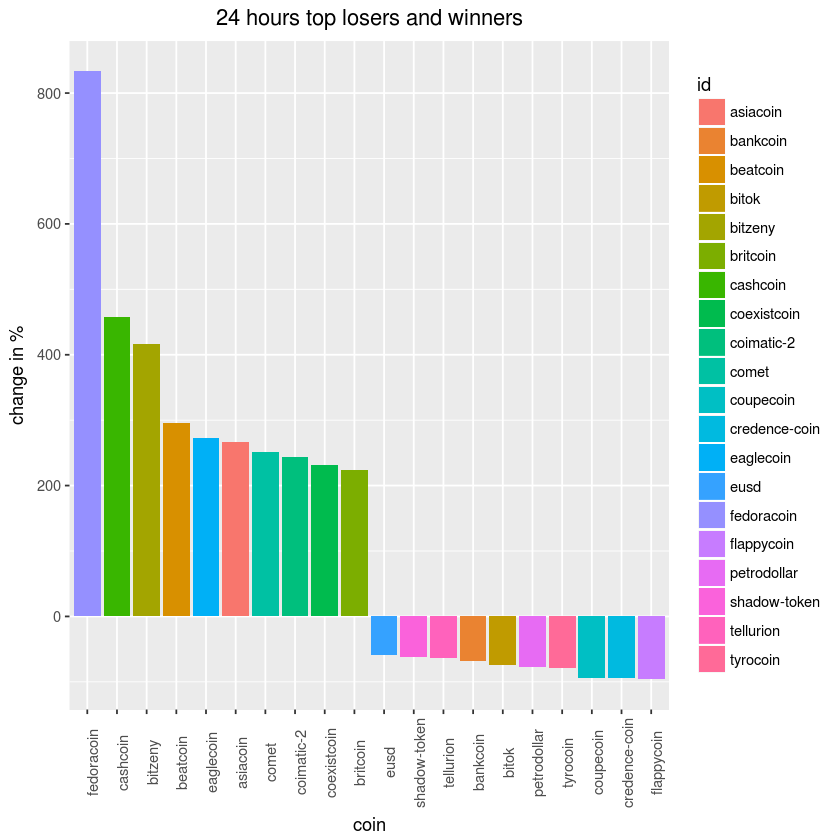

In [11]:
#Defining a function with 2 parameters, the series to plot and the title
# def top10_subplot(volatility_series, title):
    # Making the subplot and the figure for two side by side plots
#    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    # Plotting with pandas the barchart for the top 10 losers
#    ax = ...
    
    # Setting the figure's main title to the text passed as parameter
    # ... YOUR CODE FOR TASK 7 ...
    
    # Setting the ylabel to '% change'
    # ... YOUR CODE FOR TASK 7 ...
    
    # Same as above, but for the top 10 winners
#    ax = ...
    
    # Returning this for good practice, might use later
#    return fig, ax
plotvolatiles <- function(series, header) {
  seriesmap <- list(input=c('day', 'week'), mapto=c('percent_change_24h', 'percent_change_7d'))
  series <- seriesmap$mapto[seriesmap$input==series]
  t7data <- dec6 %>% select(id, percent_change_24h, percent_change_7d)
  top10winners <- head(t7data[order(t7data[,series], decreasing = T),], 10)
  top10winners <- top10winners %>% mutate(status = 'winner')
  top10losers <- head(t7data[order(t7data[,series]),], 10)
  top10losers <- top10losers %>% mutate(status = 'loser')
  topvolatiles <- rbind(top10winners, top10losers)
  ggplot(data = topvolatiles, aes(x = reorder(id, -get(series)), 
                                  y=get(series), fill=id)) + 
    geom_bar(stat = 'identity') + 
    labs(title = header, y = 'change in %', x = 'coin') + 
    theme(plot.title = element_text(hjust=0.5), axis.text.x = element_text(angle=90))
}
DTITLE = "24 hours top losers and winners"


# call function with first argument set to 'day' or 'week'.
plotvolatiles('day', DTITLE)

## 8. Ok, those are... interesting. Let's check the weekly Series too.

800% daily increase?! Why are we doing this tutorial and not buying random coins?1

After calming down, let's reuse the function defined above to see what is going weekly instead of daily.

1 Please take a moment to understand the implications of the red plots on how much value some cryptocurrencies lose in such short periods of time

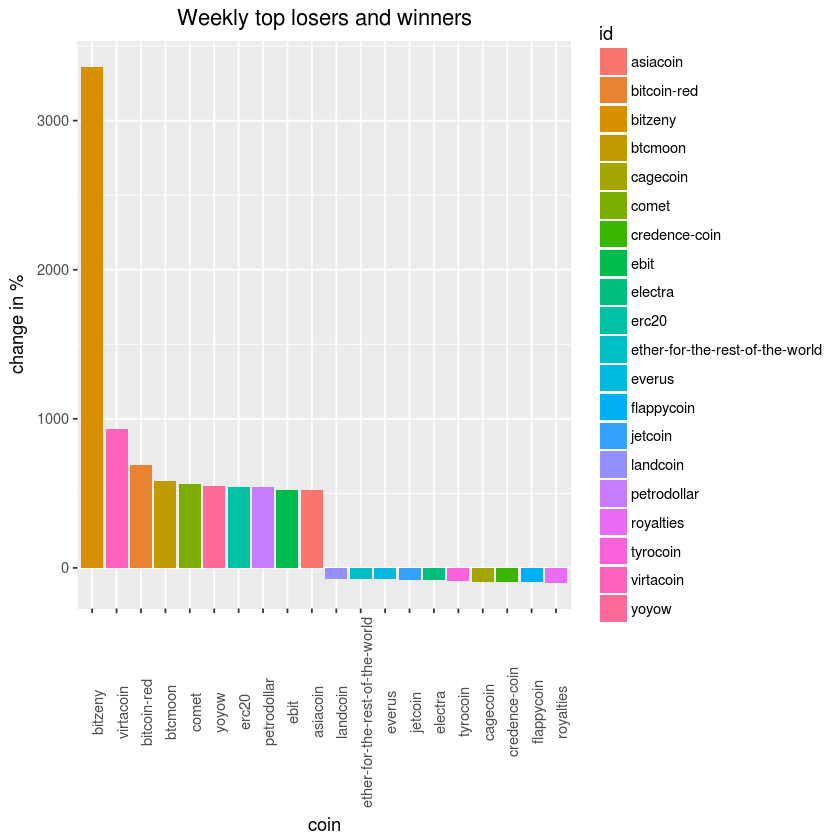

In [12]:
# Sorting in ascending order
# volatility7d = ...

WTITLE = "Weekly top losers and winners"

# Calling the top10_subplot function
# fig, ax = ...

plotvolatiles('week', WTITLE)

## 9. How small is small?

The names of the cryptocurrencies above are quite unknown, and there is a considerable fluctuation between the 1 and 7 days percentage changes. As with stocks, and many other financial products, the smaller the capitalization, the bigger the risk and reward. Smaller cryptocurrencies are less stable projects in general, and therefore even riskier investments than the bigger ones1. Let's classify our dataset based on Investopedia's capitalization definitions for company stocks.

1 Cryptocurrencies are a new asset class, so they are not directly comparable to stocks. Furthermore, there are no limits set in stone for what a "small" or "large" stock is. Finally, some investors argue that bitcoin is similar to gold, this would make them more comparable to a commodity instead.


In [10]:
# Selecting everything bigger than 10 billion 
largecaps <- cap %>% filter(market_cap_usd>10000000000)

# Printing out largecaps
# ... YOUR CODE FOR TASK 9 ...
largecaps

id,market_cap_usd
bitcoin,213049346738
ethereum,43529446198
bitcoin-cash,25295852764
iota,14752245796


## 10. Most coins are tiny

Note that many coins are not comparable to large companies in market cap, so let's divert from the original Investopedia definition by merging categories.

This is all for now. Thanks for completing this project!


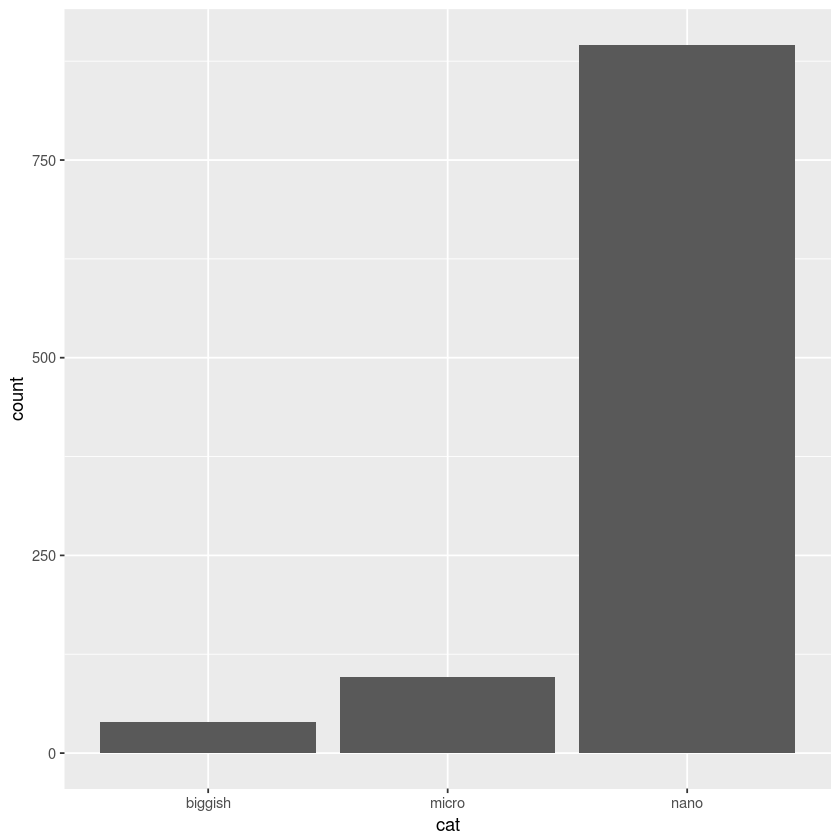

In [15]:
# Making a nice function for counting different marketcaps from the
# "cap" DataFrame. Returns an int.
# INSTRUCTORS NOTE: Since you made it to the end, consider it a gift :D
# def capcount(query_string):
#    return cap.query(query_string).count().id

capcount <- function(threshhold) {
  nrow(subset(cap, eval(parse(text=ifelse(grepl(' ', threshhold), paste('market_cap_usd', strsplit(threshhold, ' ')[[1]][1], '& market_cap_usd', strsplit(threshhold, ' ')[[1]][2]), paste('market_cap_usd', threshhold))))))
}

# Separate multiple conditions with a space

# Labels for the plot


# Using capcount count the biggish cryptos
biggish <- capcount('>=300000000')

# Same as above for micro ...
micro <- capcount('<300000000 >=50000000')

# ... and for nano
nano <- capcount('<50000000')

values <- data_frame(biggish, micro, nano)
values <- values %>% gather(biggish:nano, key='cat', value='count')
# Making a list with the 3 counts


# Plotting them with matplotlib 
# ... YOUR CODE FOR TASK 10 ...

ggplot(values, aes(x = cat, y = count)) + geom_bar(stat = 'identity')